In [3]:
# Enable inline Matplotlib
%matplotlib inline

## Imports ##
# JSON
import json

# NumPy
import numpy as np

# Pandas
import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.set_option('display.min_rows', 250)
pd.set_option('display.max_rows', 500)

# Matplotlib
import matplotlib.pyplot as plt

# SciPy
from scipy import stats

# scikit-learn
from sklearn.linear_model import LinearRegression

# seaborn
import seaborn as sns

In [4]:
beacons_inactivity_timer=5000
beacons_refresh_interval=1500

def log_loader(file_path, target_beacons, distance):
    with open(file_path) as json_file:
        log = json.load(json_file)
        log['target_beacons'] = target_beacons
        log['distance'] = distance   
        return log
    
def convert_logs_to_dataframe(logs):
    dfs = []
    for log in logs:
        table = []
        #print('Log', log['name'], 'which started at:', log['creationTimestamp'])
        #print('Focusing on:')
        for beacon in log['target_beacons']:
            #print('UUID:', beacon['uuid'], 'Major:', beacon['major'], 'Minor:', beacon['minor'])
            for entries in log['sessions'].values():
                for entry in entries:
                    #print(entry)
                    reading = entry['reading']
                    if reading['type'] == 'iBeacon' and reading['values'][0] == beacon['uuid']\
                    and reading['values'][1] == beacon['major'] and reading['values'][2] == beacon['minor']:
                        #print(reading)
                        table.append([log['name'], pd.to_datetime(log['timestamp'], unit='ms'),
                                      entry['id'], reading['id'], reading['type'], str(reading['values']),
                                      reading['values'][0], reading['values'][1], reading['values'][2],
                                      reading['txPower'], reading['rssi'],
                                      pd.to_datetime(reading['timestamp'], unit='ms'),
                                      reading['avgRssi'], log['distance']])
        df = pd.DataFrame(table, columns=['filename', 'creationTimestamp', 'entry', 'id', 'type', 'values',
                                          'uuid', 'major', 'minor', 'txPower', 'rssi', 'timestamp',
                                          'avgRssi', 'distance'])
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)[['timestamp','values', 'distance', 'rssi', 'avgRssi']]

def per_collector_device_distance(d):
    d['rssi_mean'] = d['rssi'].mean()
    d['rssi_std'] = d['rssi'].std()
    d['rssi_zscore'] = np.abs(stats.zscore(d['rssi']))
    d['rolling_mean_rssi'] = d[['timestamp', 'rssi']].rolling(pd.Timedelta(beacons_inactivity_timer, unit='ms'), on='timestamp')['rssi'].mean()
    return d

def drop_cold_samples(d):
    return d.loc[d.timestamp > d.timestamp.min()+pd.Timedelta(beacons_refresh_interval, unit='ms')]

def resample_group(d):
    return d.set_index('timestamp', verify_integrity=True).resample(pd.Timedelta(beacons_inactivity_timer, unit='ms'), label='right', closed='right').pad()

In [6]:
# Load Data
distances = np.linspace(0,10,21)
collections = {
    'laptop': {
        'distances': distances,
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 102 }]
    },
    'smartphone':  {
        'distances': distances,
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 101 }]
    }
}

tables = {}
for name, device in collections.items():
    logs = []
    for d in device['distances']:
        logs.append(log_loader('data/beacons/'+name+'/beacons-'+str(d)+'.json', device['targets'], d))
    tables[name] = convert_logs_to_dataframe(logs)
    tables[name]['device'] = name
    
data = pd.concat(tables.values(), ignore_index=True)
data = data.groupby(['device','distance']).apply(per_collector_device_distance).reset_index(drop=True)
#data = data.groupby(['device','distance']).apply(drop_cold_samples).reset_index(drop=True)
data['weight'] = 1 / data['rssi_zscore']
data.replace(np.inf, data.loc[data.weight != np.inf, 'weight'].max()*1.01, inplace=True)

data.to_csv('out/beacons.csv')
data.to_excel('out/beacons.xlsx')
data

,timestamp,values,distance,rssi,avgRssi,device,timestamp_diff,rssi_mean,rssi_std,rssi_zscore,rolling_mean_rssi,weight
0,2019-10-03 12:57:22.098,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,laptop,NaT,-52.411765,2.530528,1.420967,-56.000000,0.703746
1,2019-10-03 12:57:22.230,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,00:00:00.132000,-52.411765,2.530528,0.955076,-53.000000,1.047037
2,2019-10-03 12:57:22.515,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,00:00:00.285000,-52.411765,2.530528,0.163062,-52.666667,6.132645
3,2019-10-03 12:57:22.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,laptop,00:00:00.407000,-52.411765,2.530528,1.351083,-51.750000,0.740147
4,2019-10-03 12:57:23.059,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.000000,laptop,00:00:00.137000,-52.411765,2.530528,0.232945,-52.000000,4.292851
5,2019-10-03 12:57:23.199,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.166667,laptop,00:00:00.140000,-52.411765,2.530528,0.232945,-52.166667,4.292851
6,2019-10-03 12:57:23.331,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.714286,laptop,00:00:00.132000,-52.411765,2.530528,1.351083,-51.714286,0.740147
7,2019-10-03 12:57:23.460,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-51.875000,laptop,00:00:00.129000,-52.411765,2.530528,0.232945,-51.875000,4.292851
8,2019-10-03 12:57:23.593,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-54,-52.111111,laptop,00:00:00.133000,-52.411765,2.530528,0.628953,-52.111111,1.589945
9,2019-10-03 12:57:23.721,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-55,-52.400000,laptop,00:00:00.128000,-52.411765,2.530528,1.024960,-52.400000,0.975648


In [22]:
def resample_test(d):
    r = d.set_index('timestamp', verify_integrity=True).resample(pd.Timedelta(100, unit='ms'), label='right', closed='right').pad()
    r['timestamp_diff'] = r.index
    r['timestamp_diff'] = r['timestamp_diff'].diff()
    return r

data.groupby(['device','distance']).apply(resample_test).reset_index(drop=True)

,values,distance,rssi,avgRssi,device,timestamp_diff,rssi_mean,rssi_std,rssi_zscore,rolling_mean_rssi,weight
0,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,laptop,NaT,-52.411765,2.530528,1.420967,-56.000000,0.703746
1,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,laptop,00:00:00.100000,-52.411765,2.530528,1.420967,-56.000000,0.703746
2,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,00:00:00.100000,-52.411765,2.530528,0.955076,-53.000000,1.047037
3,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,00:00:00.100000,-52.411765,2.530528,0.955076,-53.000000,1.047037
4,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,00:00:00.100000,-52.411765,2.530528,0.955076,-53.000000,1.047037
5,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,00:00:00.100000,-52.411765,2.530528,0.163062,-52.666667,6.132645
6,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,00:00:00.100000,-52.411765,2.530528,0.163062,-52.666667,6.132645
7,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,00:00:00.100000,-52.411765,2.530528,0.163062,-52.666667,6.132645
8,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,00:00:00.100000,-52.411765,2.530528,0.163062,-52.666667,6.132645
9,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,laptop,00:00:00.100000,-52.411765,2.530528,1.351083,-51.750000,0.740147


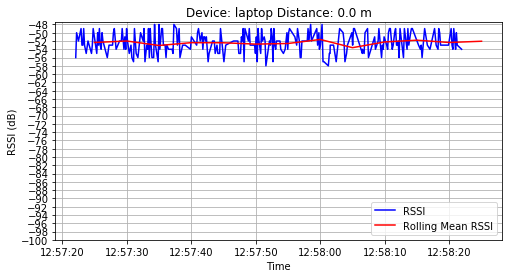

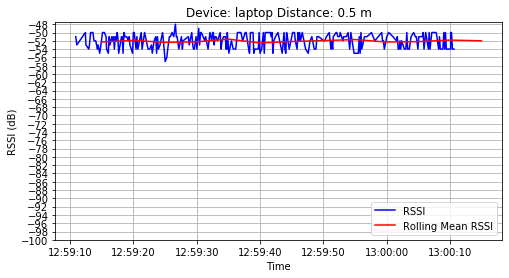

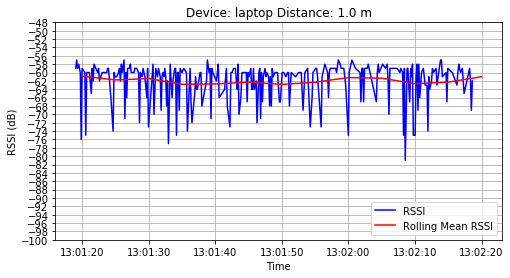

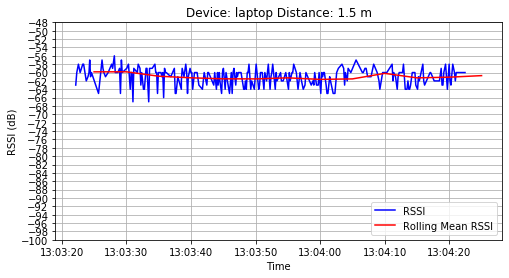

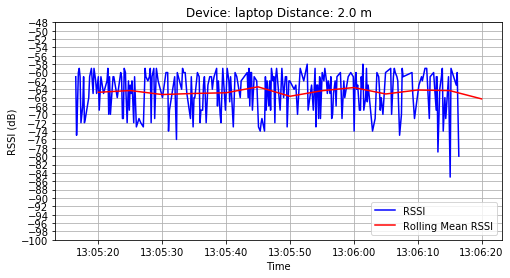

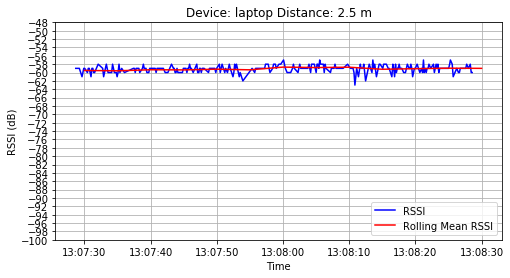

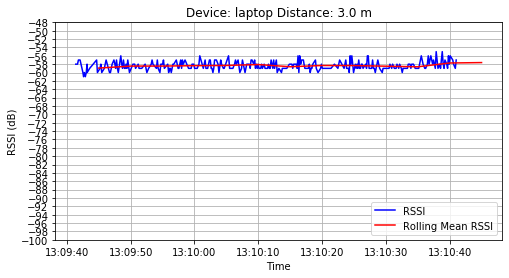

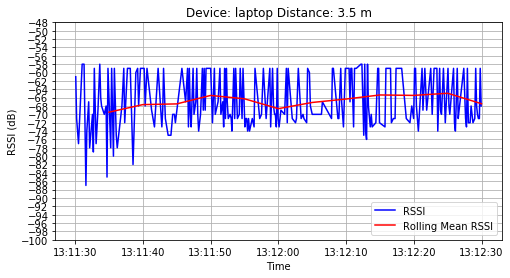

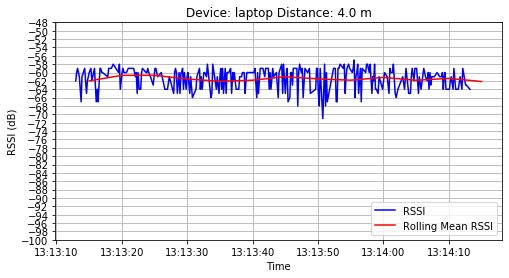

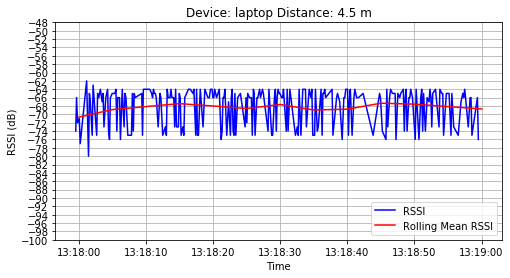

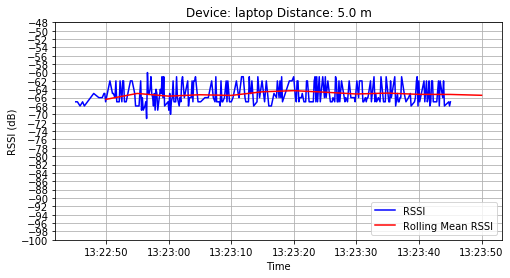

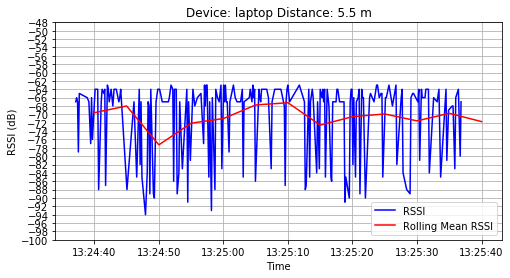

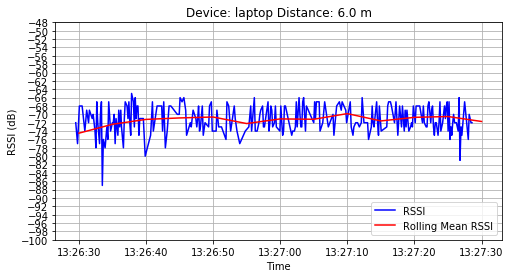

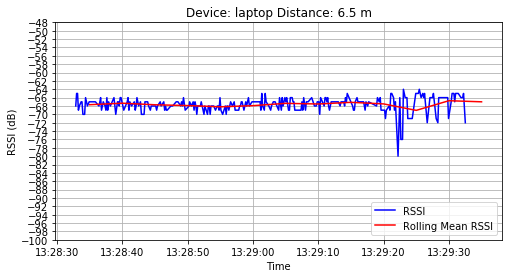

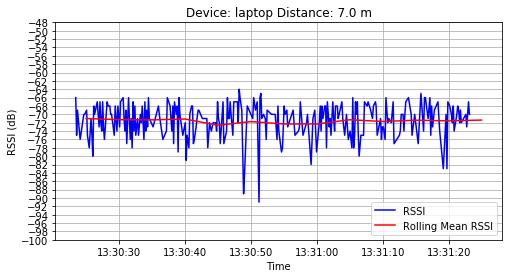

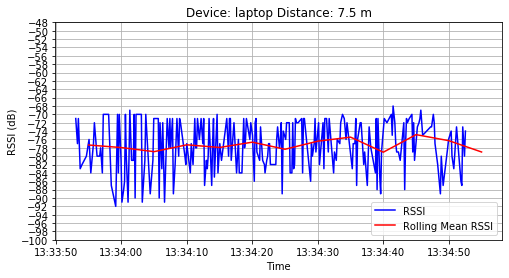

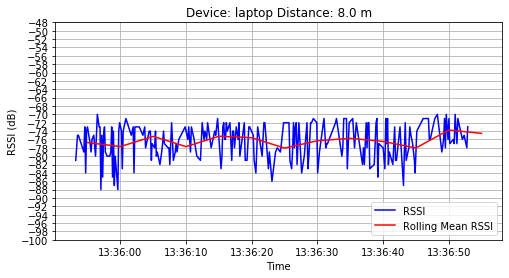

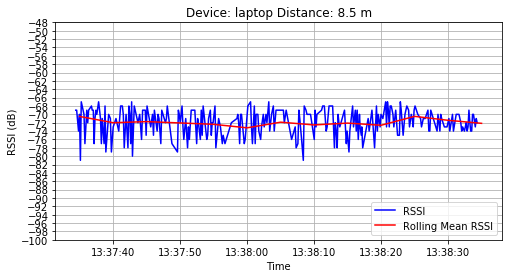

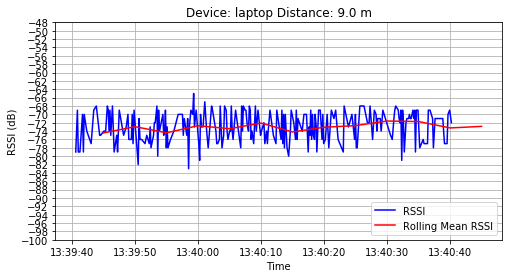

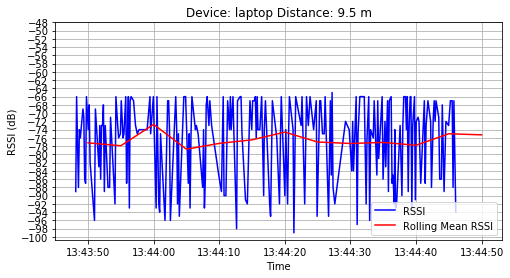

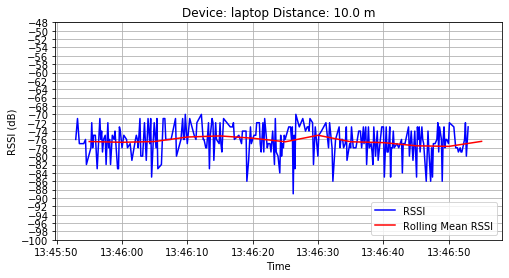

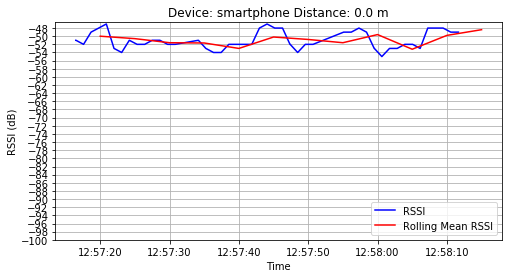

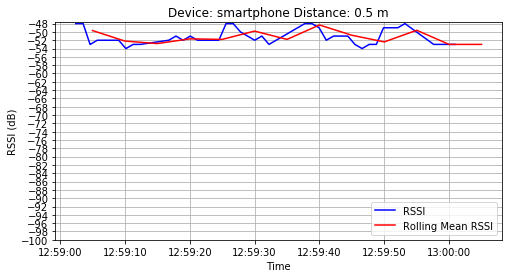

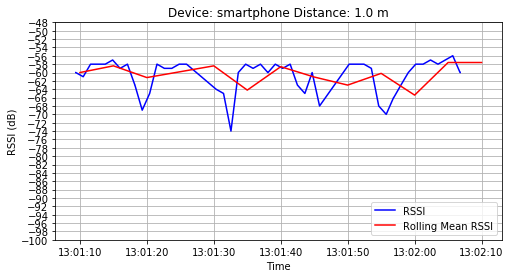

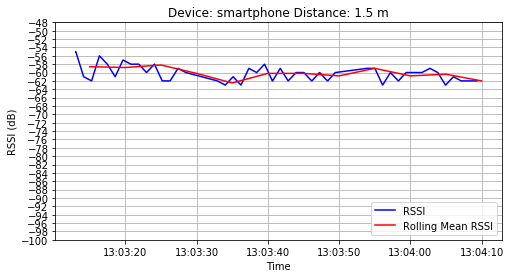

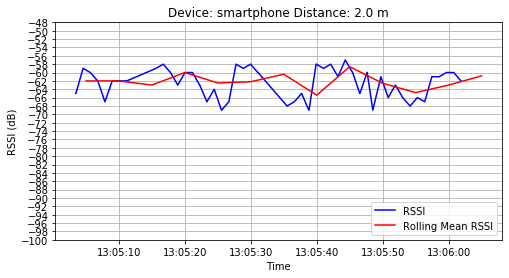

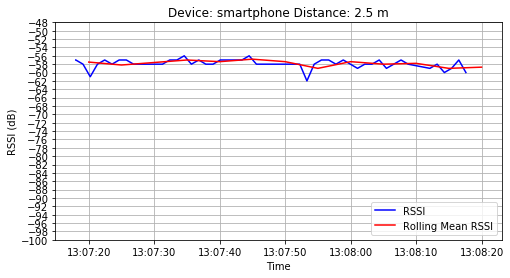

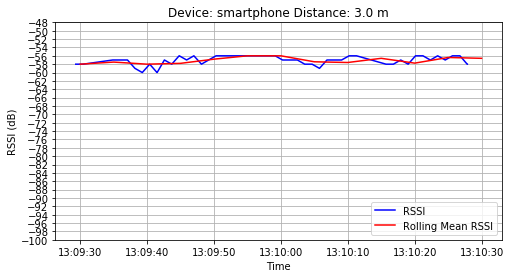

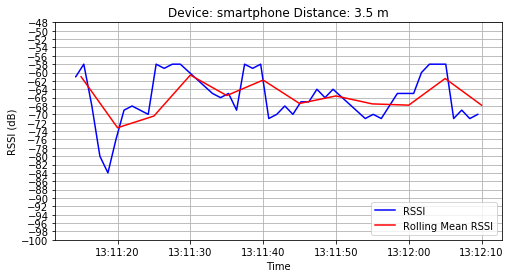

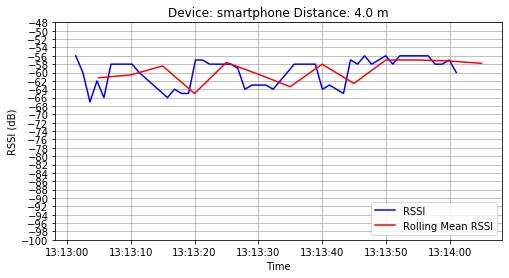

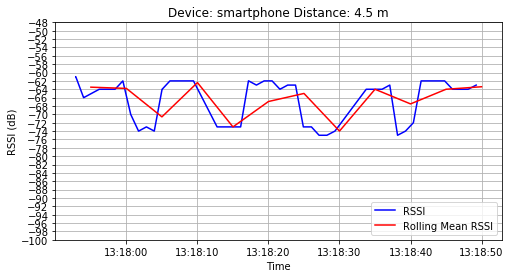

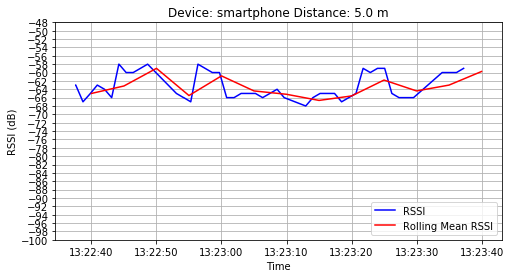

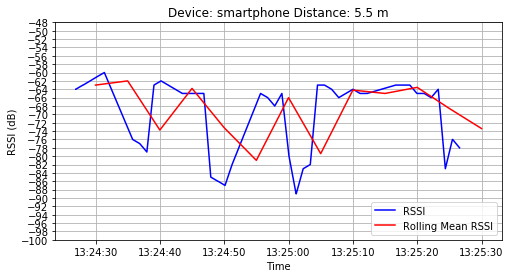

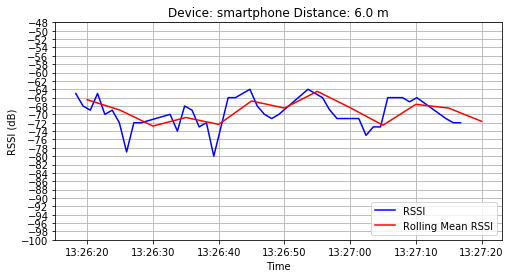

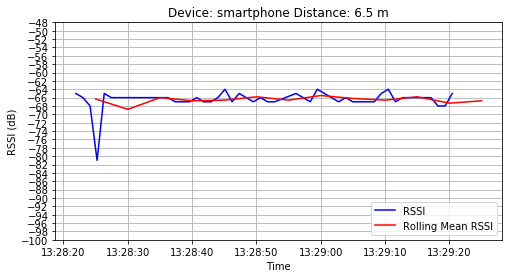

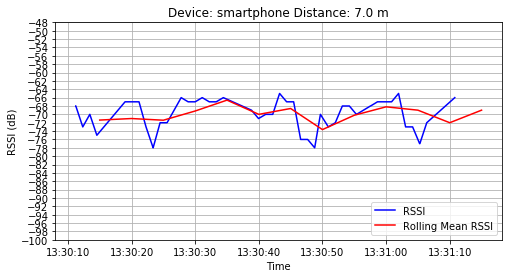

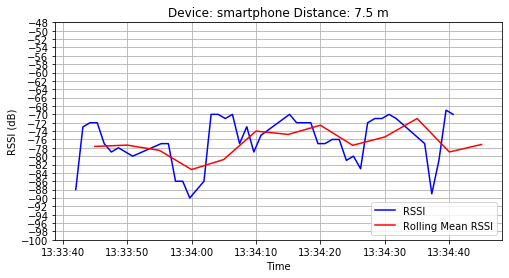

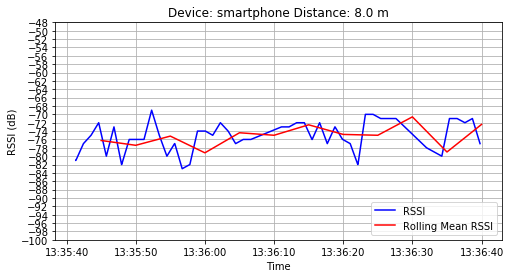

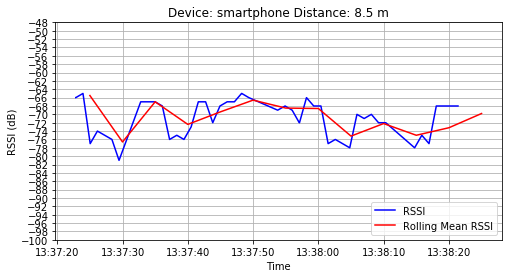

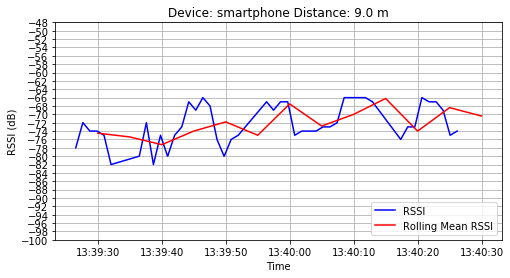

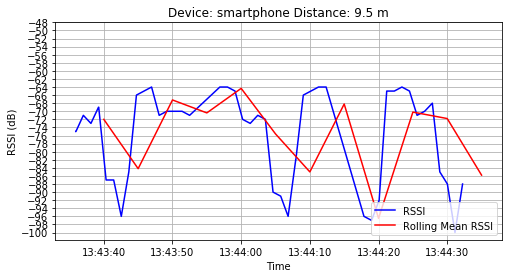

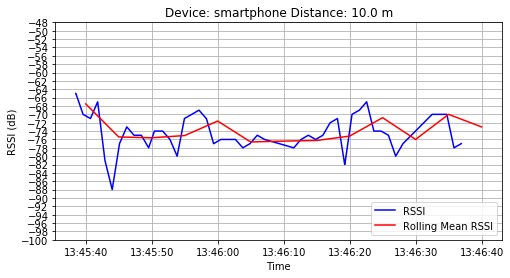

In [4]:
min_rssi = data['rssi'].min()
max_rssi = data['rssi'].max()

for k, d in data.groupby(['device','distance']):
    dr = resample_group(d)
    plt.figure(figsize=(8, 4))
    plt.title('Device: '+k[0]+' Distance: '+str(k[1])+' m')
    plt.xlabel('Time')
    plt.ylabel('RSSI (dB)')
    plt.plot(d['timestamp'], d['rssi'], label='RSSI', color='blue')
    plt.plot(dr.index, dr['rolling_mean_rssi'], label='Rolling Mean RSSI', color='red')
    plt.yticks(np.arange(min_rssi, max_rssi, 2.0))
    plt.legend(loc='lower right');
    plt.grid()
    plt.show()

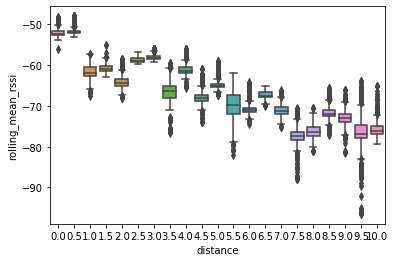

In [5]:
# Boxplot
sns.boxplot(data['distance'], data['rolling_mean_rssi'])

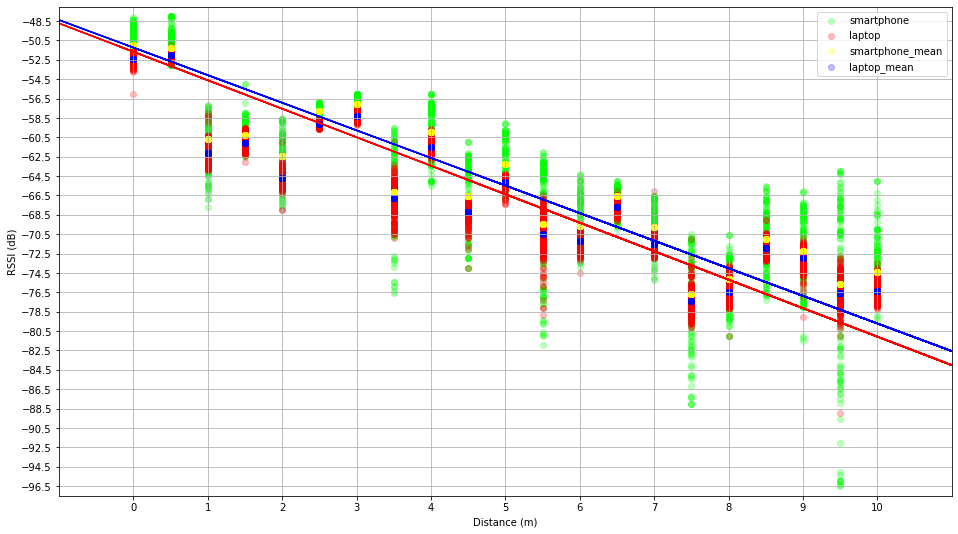

[[-0.34004932]]
[-17.56944027]


In [6]:
# Old variables for compatibility with old plots below
df_all = data #data[data.rssi_zscore < 1]
df_laptop = df_all[df_all.device == 'laptop']
df_smartphone = df_all[df_all.device == 'smartphone']

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.scatter(df_smartphone.distance, df_smartphone.rolling_mean_rssi,c='#00ff003f', label='smartphone')
ax1.scatter(df_laptop.distance, df_laptop.rolling_mean_rssi, c='#ff00003f', label='laptop')

ax1.scatter(df_smartphone.distance, df_smartphone.rssi_mean,c='#ffff003f', label='smartphone_mean')
ax1.scatter(df_laptop.distance, df_laptop.rssi_mean,c='#0000ff3f', label='laptop_mean')

X = df_all['rolling_mean_rssi'].values.reshape(-1,1)
y = df_all['distance'].values.reshape(-1,1)

lreg = LinearRegression().fit(X, y)
y_pred = lreg.predict(X)
plt.plot(y_pred, X, color='red')

wlreg = LinearRegression().fit(X, y, df_all['weight'])
wy_pred = wlreg.predict(X)
plt.plot(wy_pred, X, color='blue')

plt.xlim(min(y)-1, max(y)+1)
plt.ylim(min(X)-1, max(X)+1)
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.yticks(np.arange(min(X), max(X)+1, 2.0))
plt.grid(True)
plt.legend(loc='upper right');
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dB)')
plt.show()

#For retrieving the slope:
print(lreg.coef_)
#To retrieve the intercept:
print(lreg.intercept_)